train_images <class 'numpy.ndarray'> (60000, 28, 28) uint8
train_labels <class 'numpy.ndarray'> (60000,) uint8
test_images <class 'numpy.ndarray'> (10000, 28, 28) uint8
test_labels <class 'numpy.ndarray'> (10000,) uint8


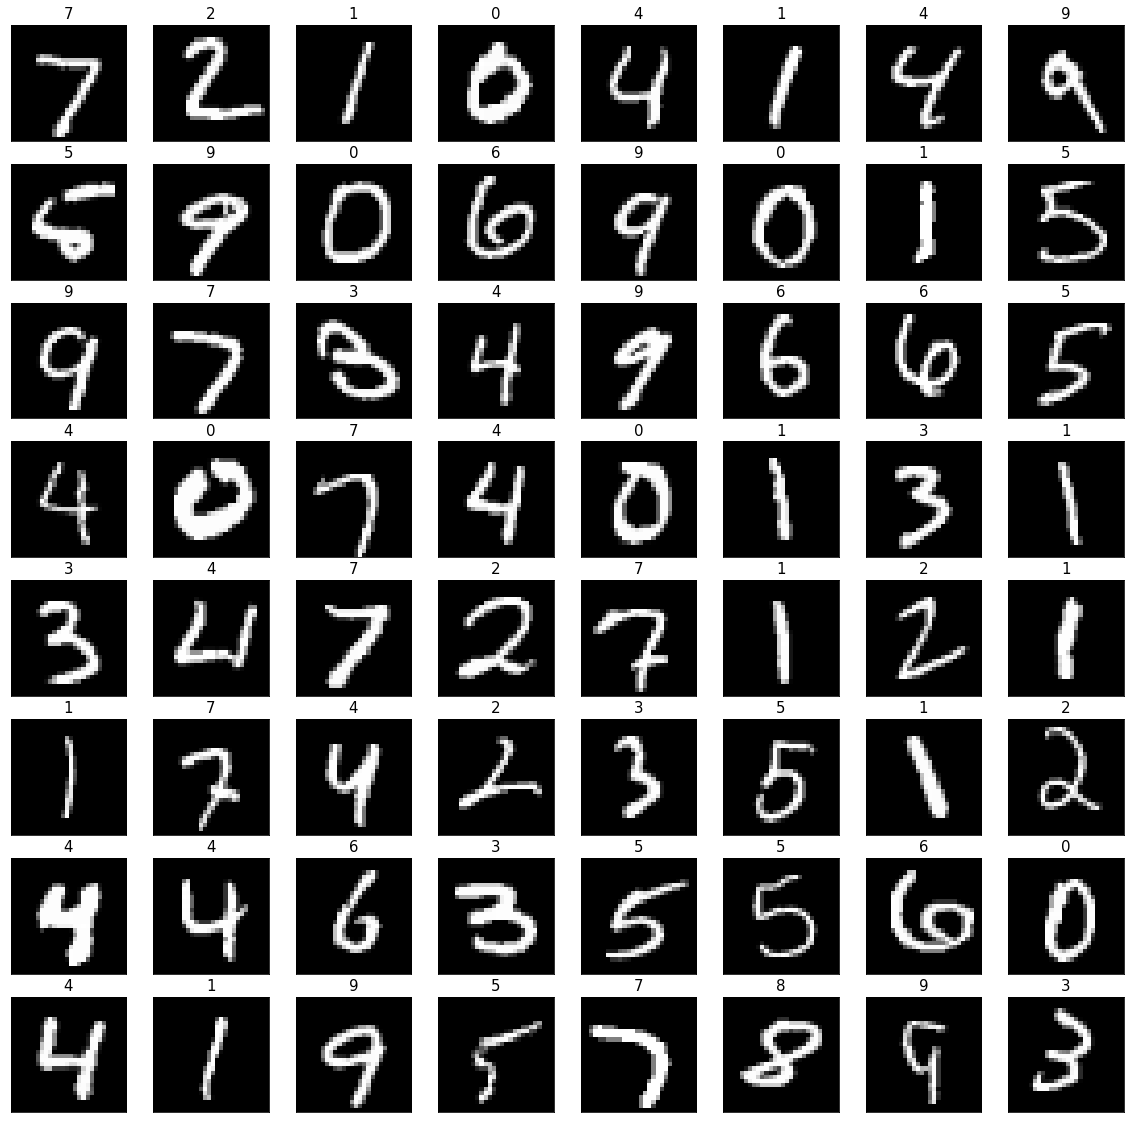

In [7]:
from keras import datasets, layers, models, utils
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

print( 'train_images', type(train_images), train_images.shape, train_images.dtype )
print( 'train_labels', type(train_labels), train_labels.shape, train_labels.dtype )
print( 'test_images', type(test_images), test_images.shape, test_images.dtype )
print( 'test_labels', type(test_labels), test_labels.shape, test_labels.dtype )

plt.figure( figsize=(20,20) )
for i in range(0, 8*8):
    plt.subplot(8,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.title( test_labels[i], {'fontsize':15} )
    plt.imshow( test_images[i], cmap="gray" )

In [8]:
K.set_image_data_format( 'channels_first' )
print( K.image_data_format() )

_, h, w = train_images.shape
train_x = ( train_images.reshape(-1, 1, h, w) / 255 ).astype('float32')
test_x = ( test_images.reshape(-1, 1, h, w) / 255 ).astype('float32')
print( 'test_x', type(test_x), test_x.shape, test_x.dtype )

channels_first
test_x <class 'numpy.ndarray'> (10000, 1, 28, 28) float32


In [9]:
num_classes = 10

print( 'test_labels', test_labels.shape, test_labels.dtype )
print( 'test_labels[0] =', test_labels[0] )

train_y = utils.to_categorical(train_labels, num_classes)
test_y = utils.to_categorical(test_labels, num_classes)

print( 'test_y', test_y.shape, test_y.dtype )
print( 'test_y[0] =', test_y[0] )

test_labels (10000,) uint8
test_labels[0] = 7
test_y (10000, 10) float32
test_y[0] = [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [10]:
x = layers.Input(shape=(1, h, w))
h = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
h = layers.MaxPooling2D(pool_size=(2, 2))(h)
h = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(h)
h = layers.MaxPooling2D(pool_size=(2, 2))(h)
h = layers.Flatten()(h)
h = layers.Dense(units=128, activation='relu')(h)
h = layers.Dropout(0.5)(h)
y = layers.Dense(units=num_classes, activation='softmax')(h)

model = models.Model(x,y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 13, 13)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 11, 11)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 5, 5)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               204928    
__________

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 4s 83us/step - loss: 0.3135 - acc: 0.9033 - val_loss: 0.0722 - val_acc: 0.9778
Epoch 2/15
54000/54000 [==============================] - 2s 35us/step - loss: 0.1053 - acc: 0.9681 - val_loss: 0.0494 - val_acc: 0.9865
Epoch 3/15
54000/54000 [==============================] - 2s 35us/step - loss: 0.0766 - acc: 0.9772 - val_loss: 0.0398 - val_acc: 0.9890
Epoch 4/15
54000/54000 [==============================] - 2s 35us/step - loss: 0.0616 - acc: 0.9813 - val_loss: 0.0328 - val_acc: 0.9903
Epoch 5/15
54000/54000 [==============================] - 2s 35us/step - loss: 0.0530 - acc: 0.9839 - val_loss: 0.0324 - val_acc: 0.9908
Epoch 6/15
54000/54000 [==============================] - 2s 35us/step - loss: 0.0469 - acc: 0.9852 - val_loss: 0.0317 - val_acc: 0.9895
Epoch 7/15
54000/54000 [==============================] - 2s 35us/step - loss: 0.0387 - acc: 0.9882 - val_loss: 0.0361 - val_acc:

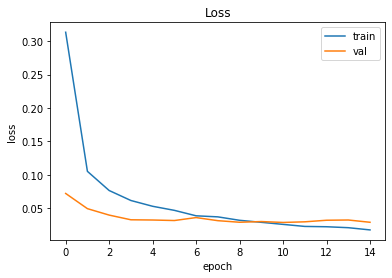

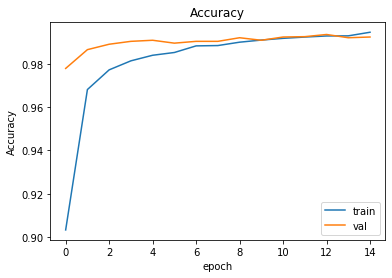

10000/10000 [==============================] - 0s 14us/step
[loss, accuracy] = [0.025636880565698083, 0.9919]


In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_x, train_y, epochs=15, batch_size=128, validation_split=0.1)

from modules.plot_history import plot_loss, plot_acc
plot_loss(hist, 'Loss')
plt.show()
plot_acc(hist, 'Accuracy')
plt.show()

evaluation = model.evaluate( test_x, test_y, batch_size=128)
print( '[loss, accuracy] =', evaluation )

weights[0].shape: (3, 3, 32, 64)
weights[1].shape: (64,)


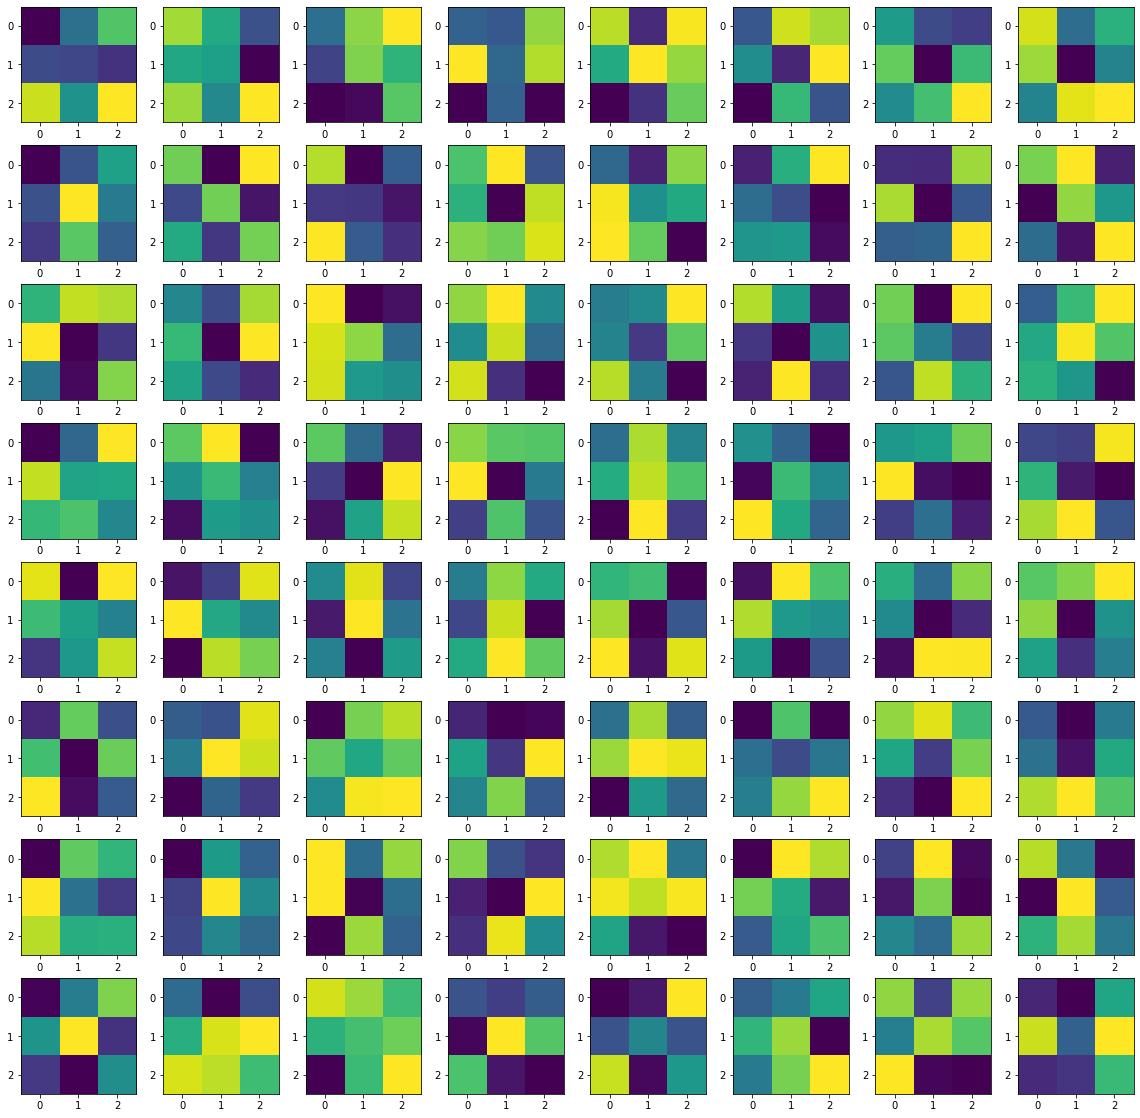

In [52]:
weights = model.get_layer(index=3).get_weights()
print('weights[0].shape:', weights[0].shape)
print('weights[1].shape:', weights[1].shape)

plt.figure(figsize=(20,20))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(weights[0][:,:,0,i])

In [17]:
conv_output = model.get_layer(index=1).output
print('conv_output:', conv_output)

conv_output: Tensor("conv2d_3/Relu:0", shape=(?, 32, 26, 26), dtype=float32)


In [25]:
layer_h = model.get_layer(index=1)   # 모델에 정의한 layer 이름
model_h = models.Model(inputs=model.input, outputs=layer_h.output)

model_h.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 26, 26)        320       
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


In [30]:
y_pred_1 = model_h.predict(test_x[1].reshape(1,1,28,28))
y_pred_1.shape

(1, 32, 26, 26)

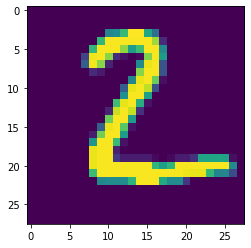

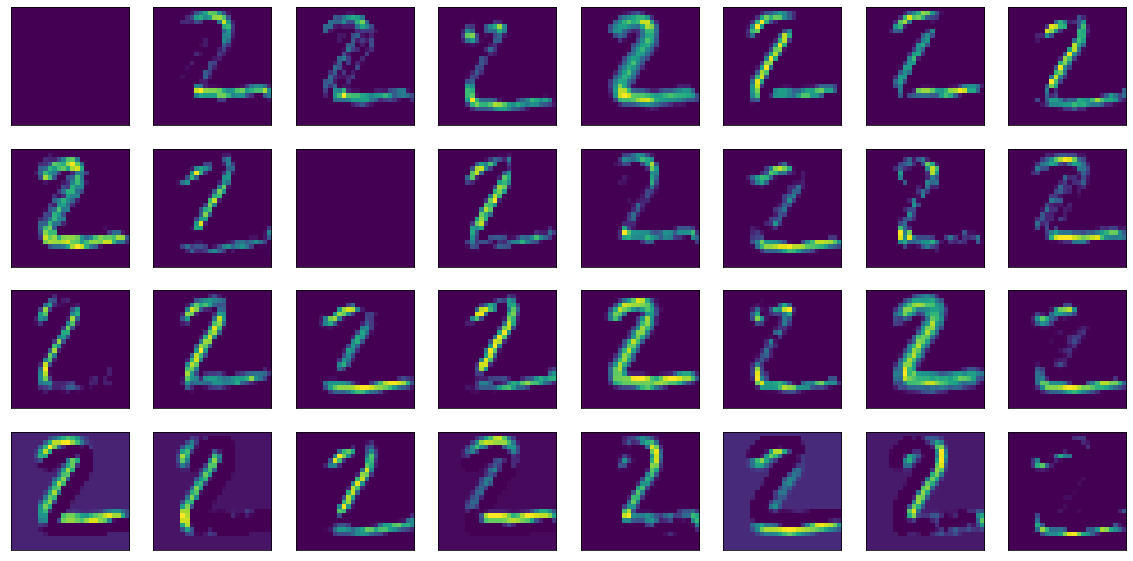

In [41]:
plt.imshow(test_images[1])

plt.figure( figsize=(20,10) )
for i in range(0,4*8):
    plt.subplot(4,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( y_pred_1[0][i] )

In [46]:
layer_h = model.get_layer(index=3)   # 모델에 정의한 layer 이름
model_h = models.Model(inputs=model.input, outputs=layer_h.output)

model_h.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 13, 13)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 11, 11)        18496     
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [47]:
y_pred_3 = model_h.predict(test_x[1].reshape(1,1,28,28))
y_pred_3.shape

(1, 64, 11, 11)

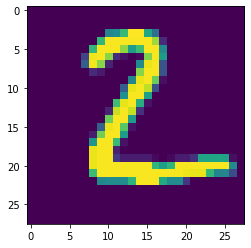

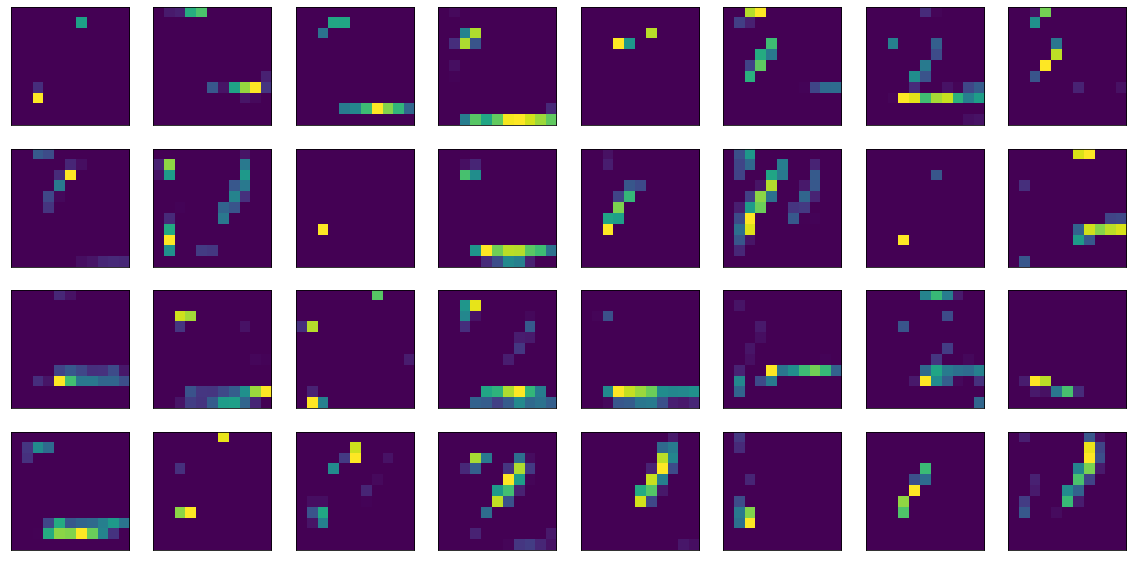

In [48]:
plt.imshow(test_images[1])

plt.figure( figsize=(20,10) )
for i in range(0,4*8):
    plt.subplot(4,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( y_pred_3[0][i] )